# Example: KPM fit with K=2

In this notebook we'll do a simple KPM fit to APOGEE disk stars to recover process parameters and amplitudes similar to those in Griffith et al. (2024).

In [1]:
import numpy as np
import kpm
from matplotlib import pyplot as plt
from astropy.io import fits

The APOGEE data needed for this example is in the ```input``` folder. ```alldata``` and ```allivars``` are numpy arrays of shape (number of stars, number of elements). The element order must be the same as ```elements``` variable.

In [2]:
elements  = np.array(['Mg','O','Si','S','Ca','CN','Na','Al','K','Cr','Fe','Ni','Mn','Co','Ce'])
alldata = np.load('input/alldata_train.npy')
allivars = np.load('input/allivars_train.npy')

Create the kpm ```abund_data``` object

In [3]:
data = kpm.abund_data(elements, alldata, allivars)

In [4]:
data

kpm.abund_data{
    Elements ------------ > ['Mg' 'O' 'Si' 'S' 'Ca' 'CN' 'Na' 'Al' 'K' 'Cr' 'Fe' 'Ni' 'Mn' 'Co' 'Ce']
    Number of elements -- > 15
    Number of stars ----- > 48659
}

Create the kpm ```fixed_param``` object. This contains information on how kpm will fit the data. Lets start with K=2, J=25 (number of parameters in the q model), an A_list with all elements, and small regularization strengths on the process amplitudes. We'll use default values for all other parameters.

In [5]:
fixed = kpm.fixed_params(data, K=2, J=11, A_list=elements, Lambda_As=np.array([1.,10.]))

In [6]:
fixed

kpm.fixed_params{
    K ------------------- > 2
    A list -------------- > ['Mg' 'O' 'Si' 'S' 'Ca' 'CN' 'Na' 'Al' 'K' 'Cr' 'Fe' 'Ni' 'Mn' 'Co' 'Ce']
    Proc elements ------- > ['Mg' 'Fe']
    fixed qs ------------ > [[1.  0. ]
 [0.4 0.6]]
    J ------------------- > 11
    Lambda As ----------- > [ 1. 10.]
    Lambda qs ----------- > [1000000.    1000.]
    xlim ---------------- > [-0.5818765   0.36397953]
}

We will save the output to the ```output``` folder. To run KPM we first initialize the model and then run the full fit. We'll do three rounds of five itterations, saving the output from each round to the output file.

Note that the output files already exist, but running this cell will recreate them.

In [7]:
file = 'output'
data, fit = kpm.initialize_2(data, fixed)
data, fixed, fit = kpm.run_kpm(data, fixed, fit, file, 'MW_disk_example', N_itters=5, 
                               overwrite=True, verbose=False)

File output/MW_disk_example_K2_qccFe0.4_J11_0.out exists, but overwriting
File output/MW_disk_example_K2_qccFe0.4_J11_1.out exists, but overwriting
File output/MW_disk_example_K2_qccFe0.4_J11_2.out exists, but overwriting


Lets take a look at the results.

Here we plot the q vectors from this fit, comparing them to the q vectors from Griffith et al. (2023). Note that because of a change in the q implementation, the new process vectors are much smoother.

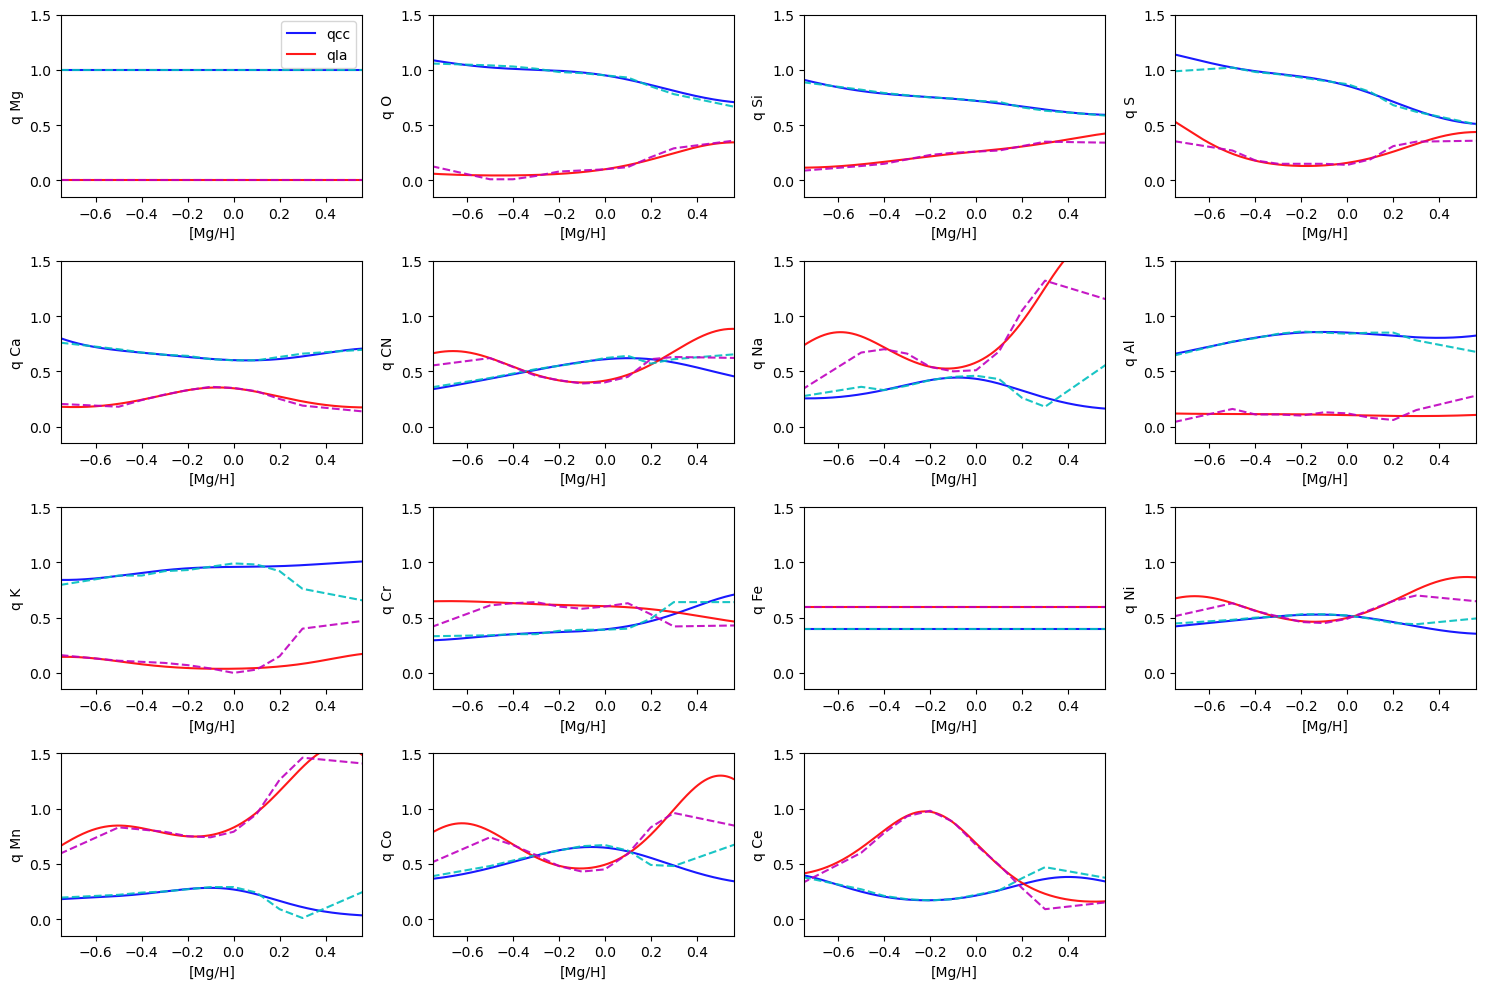

In [8]:
kpm.plot_qs(data, fixed, fit)

hdu_qcc = fits.open('../../Tables/KPM_qcc_K2.fits')
hdu_qIa = fits.open('../../Tables/KPM_qIa_K2.fits')
for i in range(data.M):
    plt.subplot(4,4,i+1)
    MgH = hdu_qcc[1].data.Mg_H
    elem = data.elements[i]
    if elem == 'CN': elem='C+N'
    qcc = hdu_qcc[1].data['qcc_'+elem]
    qIa = hdu_qIa[1].data['qIa_'+elem]

    plt.plot(MgH, qcc, 'c--', alpha=0.9, label='qcc_old')
    plt.plot(MgH, qIa, 'm--', alpha=0.9, label='qIa_old')

Here we plot the A values for all stars. The bimodal population resembles a plot of [Fe/Mg] vs. [Mg/H]

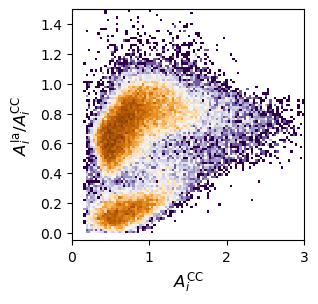

In [9]:
kpm.plot_As(fit)

Here we plot the observed abundance distribution, the predicted abundance distribution (including noise) and the residual. This can be used to visually diagnose the goodness of the KPM fit.

/Users/emilygriffith/KProcessModel/API/kpm/visualize.py:80: RuntimeWarning: divide by zero encountered in divide
  synthnoise = _RNG2.normal(size=synthdata.shape) / data.sqrt_allivars


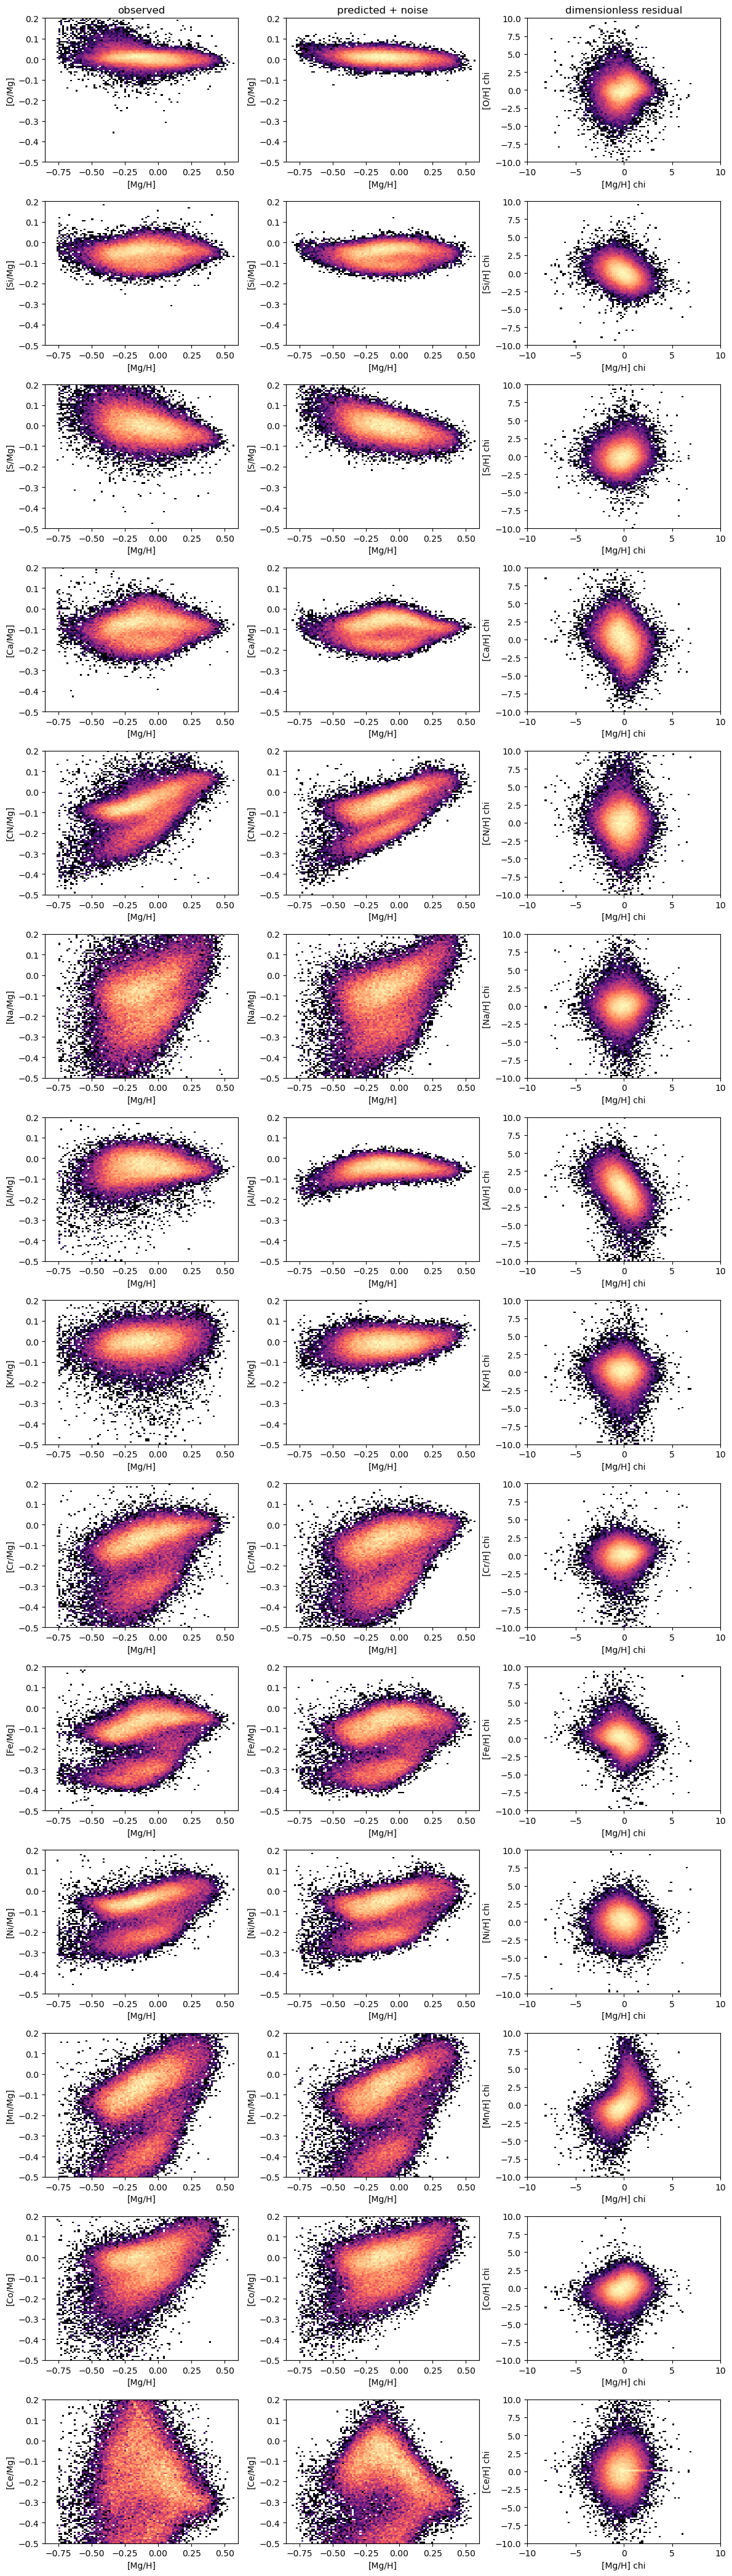

In [10]:
kpm.plot_model_abundances(data, fixed, fit, noise=True)